# Description

The notebook automates the process of pushing a pair of scenarios (baseline and alternative) through the simulation and optimization pipeline, comparing outputs for each scenario. Key outputs include harvested area (hectares), harvested volume (m³), and growth (m³). The notebook also reports stand age class distribution, old growth attributes, and tree species diversity at the beginning and end of the planning horizon for each scenario. Additionally, it calculates biodiversity and socioeconomic indicators, while quantifying differences between baseline and alternative scenarios in terms of carbon stocks and net emissions over a customizable simulation horizon, set to 100 years by default (the system can easily be parametrized to simulate shorter or longer horizons).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
import ws3.forest
import time
import gurobipy as grb
import pickle
import libcbm
import os
from util import compile_events, cbm_report, compile_scenario_maxstock, plot_scenario_maxstock, run_cbm_emissionstock, run_scenario, plugin_c_curves, plugin_c_curves, cbm_report_both, compare_ws3_cbm, compare_ws3_cbm_both, track_system_stock, track_system_emission, compile_scenario_minemission, plot_scenario_minemission, kpi_age, kpi_species, cmp_c_ss, cmp_c_se, results_scenarios, bootstrap_ogi, compare_kpi_age, epsilon_computer, epsilon_computer_bd

In [3]:
# Initialize the input parameters
base_year = 2020
horizon = 10
period_length = 10
max_age = 1000
n_steps = 100
tvy_name = 'totvol'
max_harvest = 1.0

In [4]:
# Load the CSV file
file_path = "./data/AACs.csv"  # Update with your file path if needed
df = pd.read_csv(file_path)

# Convert to dictionary where TSA is the key and AAC is the value
aac_dict = dict(zip(df['TSA'], df['AAC']))

# Display the resulting dictionary
print(aac_dict)


{'tsa01': 500000, 'tsa02': 670142, 'tsa03': 840331, 'tsa04': 119791, 'tsa05': 808000, 'tsa07': 485000, 'tsa08': 2582350, 'tsa09': 424800, 'tsa10': 329024, 'tsa11': 2100000, 'tsa12': 1087000, 'tsa13': 550000, 'tsa14': 970000, 'tsa15': 375000, 'tsa16': 2321476, 'tsa17': 337574, 'tsa18': 1200000, 'tsa20': 1576043, 'tsa22': 2462800, 'tsa23': 967805, 'tsa24': 6935023, 'tsa25': 272061, 'tsa26': 2607000, 'tsa27': 225000, 'tsa29': 2937509, 'tsa30': 1220808, 'tsa31': 368276, 'tsa38': 315694, 'tsa39': 1050000, 'tsa40': 2115000, 'tsa41': 1791846, 'tsa43': 865000, 'tsa44': 845286, 'tsa45': 346920}


In [5]:
# Define scenario options based on case study


scenario_options = {

    'test': ['evenflow_cons', 'no_cons'],
    'ecotrust': ['lowest carbon stock', 'business as usual', '40% of highest carbon stock', '60% of highest carbon stock', '20% of highest carbon stock', 'highest carbon stock']
}
# scenario_options = {

#     'test': ['evenflow_cons'],
#     'ecotrust': ['business as usual', '40% of highest carbon stock']
# }
# Function to handle case study selection and update scenario dropdown
def select_case_study(case_study):
    print(f"Selected case study: {case_study}")
    # Update the scenario dropdown based on the selected case study
    scenario_dropdown.options = scenario_options.get(case_study, [])
    scenario_dropdown.value = scenario_options[case_study][0]  # Set a default value


case_study_dropdown = widgets.Dropdown(
    options=['test', 'ecotrust'],
    value='ecotrust',
    description='Case Study:'
)
case_study_dropdown.observe(lambda change: select_case_study(change['new']), names='value')
display(case_study_dropdown)

# Function to handle scenario selection
def select_scenario(scenario_name):
    print(f"Selected scenario: {scenario_name}")

# Scenario dropdown
scenario_dropdown = widgets.Dropdown(
    options=scenario_options['ecotrust'],  # Set initial options based on default case study
    value=scenario_options['ecotrust'][0],  # Set initial value
    description='Scenario:'
)
scenario_dropdown.observe(lambda change: select_scenario(change['new']), names='value')
display(scenario_dropdown)

# Function to handle objective functon
def select_obj(obj_mode):
    print(f"Selected objective: {obj_mode}")
obj_dropdown = widgets.Dropdown(
    options=['max_hv', 'min_ha', 'max_st', 'min_em'],
    value='max_hv',
    description='Objective:'
)
display(obj_dropdown)
obj_dropdown.observe(lambda change: select_obj(change['new']), names='value')

Dropdown(description='Case Study:', index=1, options=('test', 'ecotrust'), value='ecotrust')

Dropdown(description='Scenario:', options=('lowest carbon stock', 'business as usual', '40% of highest carbon …

Dropdown(description='Objective:', options=('max_hv', 'min_ha', 'max_st', 'min_em'), value='max_hv')

In [6]:
# Initialize main widget components 
hwp_pool_effect = widgets.FloatSlider(min=0, max=1, step=1, description='HWP_effect', value=0, layout=widgets.Layout(margin='10px 0'))
release_immediately = widgets.FloatSlider(min=0, max=1, step=1, description='Release immediately', value=0, layout=widgets.Layout(margin='10px 0'))
displacement_effect = widgets.FloatSlider(min=0, max=1, step=1, description='Displacement', value=1, layout=widgets.Layout(margin='10px 0'))
clt_percentage = widgets.FloatSlider(min=0, max=1, step=0.1, description='CLT_percent:', value=0.5, layout=widgets.Layout(margin='10px 0'))
credibility = widgets.FloatSlider(min=0, max=1, step=0.1, description='Credibility:', value=1, layout=widgets.Layout(margin='10px 0'))
# max_harvest = widgets.FloatSlider(min=0, max=1, step=0.05, description='Max_harvest:', value=1.0, layout=widgets.Layout(margin='10px 0'))
budget_input = widgets.FloatText(value=10000000, description='Budget:', layout=widgets.Layout(margin='10px 0'))

release_immediately.layout.display = 'none' if hwp_pool_effect.value != 0 else 'block'
displacement_effect.layout.display = 'block' if hwp_pool_effect.value != 0 else 'none'
clt_percentage.layout.display = 'block' if hwp_pool_effect.value != 0 and displacement_effect.value != 0 else 'none'
credibility.layout.display = 'block' if hwp_pool_effect.value != 0 and displacement_effect.value != 0 else 'none'

container = widgets.VBox([
    hwp_pool_effect, release_immediately, displacement_effect, clt_percentage, credibility, budget_input  
    # ,max_harvest
])

display(container)

def update_widgets(change):
    hwp_pool_effect_value = hwp_pool_effect.value
    displacement_effect_value = displacement_effect.value

    release_immediately.layout.display = 'block' if hwp_pool_effect_value == 0 else 'none'
    displacement_effect.layout.display = 'block' if hwp_pool_effect_value != 0 else 'none'

    clt_percentage.layout.display = 'block' if hwp_pool_effect_value != 0 and displacement_effect_value != 0 else 'none'
    credibility.layout.display = 'block' if hwp_pool_effect_value != 0 and displacement_effect_value != 0 else 'none'

hwp_pool_effect.observe(update_widgets, names='value')
displacement_effect.observe(update_widgets, names='value')

In [7]:
#Start Calculating the Running Time
Start = time.time()

In [8]:
case_study = case_study_dropdown.value
scenario_name = scenario_dropdown.value
obj_mode = obj_dropdown.value
hwp_pool_effect_value = hwp_pool_effect.value
release_immediately_value = release_immediately.value if hwp_pool_effect_value == 0 else 0
displacement_effect = displacement_effect.value if hwp_pool_effect_value != 0 else 0
clt_percentage = clt_percentage.value if displacement_effect != 0 else 0
credibility = credibility.value if displacement_effect != 0 else 0
# max_harvest = max_harvest.value
budget_input = budget_input.value

In [9]:
scenario_name

'lowest carbon stock'

In [10]:
obj_mode

'max_hv'

In [11]:
# Define case study mappings and retrieve model details based on case study
case_study_options = {
    'test': {
        'model_name': 'ecotrust',
        'model_path': './data/woodstock_model_files_ecotrust'
    },
    'ecotrust': {
        'model_name': 'ecotrust',
        'model_path': './data/woodstock_model_files_ecotrust'
    }
}

model_info = case_study_options.get(case_study)

if model_info:
    model_name = model_info['model_name']
    model_path = model_info['model_path']
else:
    print('The case study name is not valid')


In [12]:
# Create and Run `ForestModel` instance
fm = ws3.forest.ForestModel(model_name=model_name,
                            model_path=model_path,
                            base_year=base_year,
                            horizon=horizon,
                            period_length=period_length,
                            max_age=max_age)
fm.import_landscape_section()
fm.import_areas_section()
fm.import_yields_section()
fm.import_actions_section()
fm.import_transitions_section()
fm.initialize_areas()
fm.add_null_action()
fm.reset_actions()
fm.grow()

In [13]:
# Define Disturance Types
disturbance_type_mapping = [{'user_dist_type': 'harvest', 'default_dist_type': 'Clearcut harvesting without salvage'},
                            {'user_dist_type': 'fire', 'default_dist_type': 'Wildfire'}]
for dtype_key in fm.dtypes:
    fm.dt(dtype_key).last_pass_disturbance = 'fire' if dtype_key[2] == dtype_key[4] else 'harvest'

In [14]:
sit_config, sit_tables = fm.to_cbm_sit(softwood_volume_yname='swdvol', 
                                       hardwood_volume_yname='hwdvol', 
                                       admin_boundary='British Columbia', 
                                       eco_boundary='Montane Cordillera',
                                       disturbance_type_mapping=disturbance_type_mapping,
                                       include_empty_dtypes=True)

In [15]:
# Flag 'harvest' as a harvesting action in the ws3 model
harvest_acode='harvest'
fm.actions[harvest_acode].is_harvest = True

In [16]:
# Define Carbon Pools
biomass_pools = ['SoftwoodMerch','SoftwoodFoliage', 'SoftwoodOther', 'SoftwoodCoarseRoots','SoftwoodFineRoots',                    
                 'HardwoodMerch', 'HardwoodFoliage', 'HardwoodOther', 'HardwoodCoarseRoots', 'HardwoodFineRoots']
dom_pools = ['AboveGroundVeryFastSoil', 'BelowGroundVeryFastSoil', 'AboveGroundFastSoil', 'BelowGroundFastSoil',
             'MediumSoil', 'AboveGroundSlowSoil', 'BelowGroundSlowSoil', 'SoftwoodStemSnag', 'SoftwoodBranchSnag',
             'HardwoodStemSnag', 'HardwoodBranchSnag']
emissions_pools = ['CO2', 'CH4', 'CO', 'NO2']
products_pools = ['Products']
ecosystem_pools = biomass_pools + dom_pools
all_pools = biomass_pools + dom_pools + emissions_pools + products_pools

Emissions from all biomass components only resulting from fire disturbance, while these from all DOM pools resulting from annual decay processes and fire disturbance.

In [17]:
# Define Carbon Fluxes
annual_process_fluxes = [
    'DecayDOMCO2Emission',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir'
]

npp_fluxes=[
    'DeltaBiomass_AG', 
    'DeltaBiomass_BG'
]

decay_emissions_fluxes = [
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir'
]

disturbance_production_fluxes = [
    'DisturbanceSoftProduction',
    'DisturbanceHardProduction',
    'DisturbanceDOMProduction'   
]

disturbance_emissions_fluxes = [
    'DisturbanceMerchToAir',
    'DisturbanceFolToAir',
    'DisturbanceOthToAir',
    'DisturbanceCoarseToAir',
    'DisturbanceFineToAir',
    'DisturbanceVFastAGToAir',
    'DisturbanceVFastBGToAir',
    'DisturbanceFastAGToAir',
    'DisturbanceFastBGToAir',
    'DisturbanceMediumToAir',
    'DisturbanceSlowAGToAir',
    'DisturbanceSlowBGToAir',
    'DisturbanceSWStemSnagToAir',
    'DisturbanceSWBranchSnagToAir',
    'DisturbanceHWStemSnagToAir',
    'DisturbanceHWBranchSnagToAir'   
]

all_fluxes = [
    'DisturbanceCO2Production',
    'DisturbanceCH4Production',
    'DisturbanceCOProduction',
    'DisturbanceBioCO2Emission',
    'DisturbanceBioCH4Emission',
    'DisturbanceBioCOEmission',
    'DecayDOMCO2Emission',
    'DisturbanceSoftProduction',
    'DisturbanceHardProduction',
    'DisturbanceDOMProduction',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir',
    'DisturbanceMerchToAir',
    'DisturbanceFolToAir',
    'DisturbanceOthToAir',
    'DisturbanceCoarseToAir',
    'DisturbanceFineToAir',
    'DisturbanceDOMCO2Emission',
    'DisturbanceDOMCH4Emission',
    'DisturbanceDOMCOEmission',
    'DisturbanceMerchLitterInput',
    'DisturbanceFolLitterInput',
    'DisturbanceOthLitterInput',
    'DisturbanceCoarseLitterInput',
    'DisturbanceFineLitterInput',
    'DisturbanceVFastAGToAir',
    'DisturbanceVFastBGToAir',
    'DisturbanceFastAGToAir',
    'DisturbanceFastBGToAir',
    'DisturbanceMediumToAir',
    'DisturbanceSlowAGToAir',
    'DisturbanceSlowBGToAir',
    'DisturbanceSWStemSnagToAir',
    'DisturbanceSWBranchSnagToAir',
    'DisturbanceHWStemSnagToAir',
    'DisturbanceHWBranchSnagToAir'
]

grossgrowth_ag = [
    "DeltaBiomass_AG",
    "TurnoverMerchLitterInput",
    "TurnoverFolLitterInput",
    "TurnoverOthLitterInput",
]

grossgrowth_bg = [
    "DeltaBiomass_BG",
    "TurnoverCoarseLitterInput",
    "TurnoverFineLitterInput",
]

product_flux = [
     "DisturbanceSoftProduction",
     "DisturbanceHardProduction",
     "DisturbanceDOMProduction",
]

In [18]:
# Define Sum Carbon Pools and Sum Carbon Fluxes
total_emission = decay_emissions_fluxes + disturbance_emissions_fluxes
gross_growth = grossgrowth_ag + grossgrowth_bg

sum_pools = ['ecosystem', 'biomass', 'DOM']
sum_fluxes = ['total_emission', 'gross_growth', 'net_emission']

In [19]:
# Read carbon curves
# file_directory = "./data/curves"
file_names = ["pi.csv", "fi.csv"]
# loaded_data = {}
file_path = ["./data/curves/pi.csv", "./data/curves/fi.csv"] 
pi = pd.read_csv(file_path[0], index_col=0)
fi = pd.read_csv(file_path[1], index_col=0)
# for filename in file_names:
#     file_path = os.path.join(file_directory, filename)
#     with open(file_path, 'rb') as file:
#         loaded_data[filename] = pickle.load(file)
#     print(f"Loaded data from {file_path}")

# c_curves_p = loaded_data.get(f"{case_study}_c_curves_p.pkl")
# c_curves_f = loaded_data.get(f"{case_study}_c_curves_f.pkl")

In [20]:
# Generate Carbon Pool anf Flux Curves
c_curves_p = pi.groupby(['dtype_key', 'timestep'], as_index=True)[ecosystem_pools].sum()
c_curves_f = fi.groupby(['dtype_key', 'timestep'], as_index=True)[all_fluxes].sum()

In [21]:
# Generate sum carbon pool curves
c_curves_p['ecosystem'] = c_curves_p[ecosystem_pools].sum(axis=1)
c_curves_p['biomass'] = c_curves_p[biomass_pools].sum(axis=1)
c_curves_p['DOM'] = c_curves_p[dom_pools].sum(axis=1)

In [22]:
c_curves_f['total_emission'] = 44/12 * c_curves_f[total_emission].sum(axis=1)
c_curves_f['gross_growth'] = 44/12 * c_curves_f[gross_growth].sum(axis=1)
c_curves_f['net_emission'] = c_curves_f['total_emission'] - c_curves_f['gross_growth']

In [23]:
c_curves_f.loc[c_curves_f.index.get_level_values('timestep') == 0] = c_curves_f.loc[c_curves_f.index.get_level_values('timestep') == 1].values

In [24]:
# Plug carbon and old groth yield curves into forest model
plugin_c_curves(fm, c_curves_p, c_curves_f)
bootstrap_ogi(fm)

running maximizing biodiversity scenario
[21509.2763886455, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[430.9548976744, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
maximum biodiversity is : 215092.76388645495
running maximizing carbon stock scenario
minimum biodiversity_1 is: 159295.33158089613
running maximizing carbon stock scenario
minimum biodiversity_2 is: 215092.76388645495
running maximizing stock scenario
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
maximum stock is : 6788534.263521082
running maximizing harvesting scenario
minimum stock is: 5148721.781749598
163981.2481771484
Running for ecotrust_max_hv_lowest carbon stock...
running lowest carbon stock scenario


/media/data/home/sghotb/.virtualenvs/foo/lib/python3.10/site-packages/pulp/pulp.py:1298: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


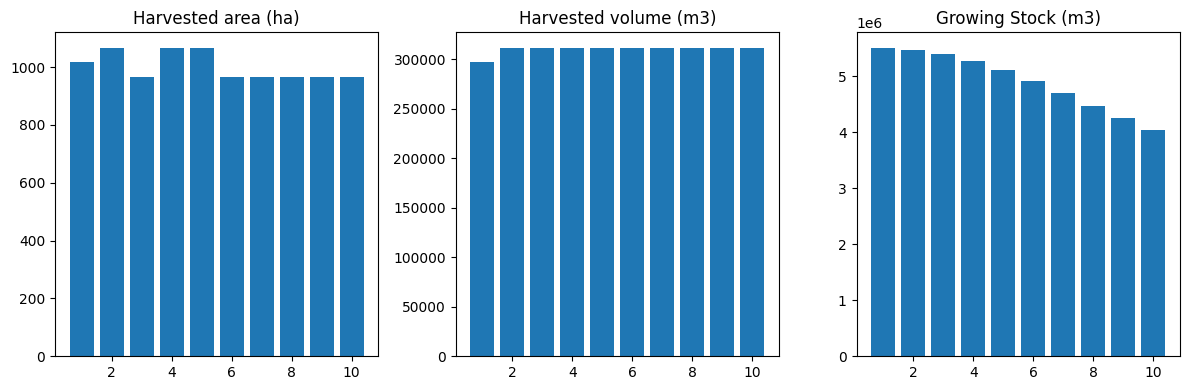

Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_lowest carbon stock_scheduling.pdf


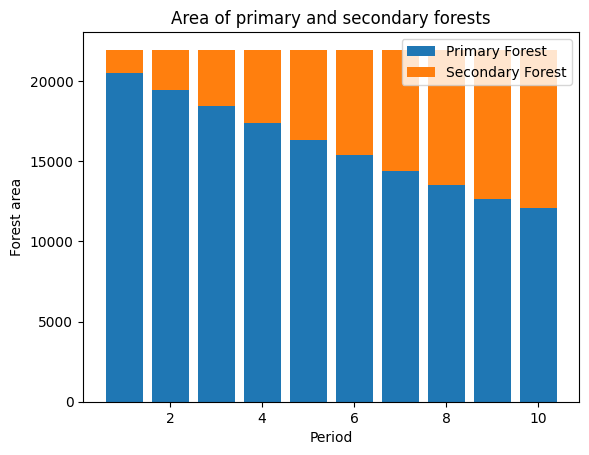

------------------------------------------------
The scocial indicator (the number of job creation) is:  3280
The economic indicator (the provincial government revenues) is:  111866
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.
Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_lowest carbon stock_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                   0           10   Difference
Cedar     283.576558  1159.035069   875.458510
Aspen      42.290489   185.519499   143.229009
Spruce   4471.720232  3075.676123 -1396.044109
Hem      1246.520025   734.753555  -511.766471
Birch       3.090902    40.119295    37.028393
Bal      3699.410838  4108.075859   408.665021
DougFir   504.920628   860.516017   355.595390
Pine      156.364968   156.393578     0.028610

Old growth has **decreased** by -87.81 hectares from time period 0 to ti

/media/data/home/sghotb/.virtualenvs/foo/lib/python3.10/site-packages/pulp/pulp.py:1298: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


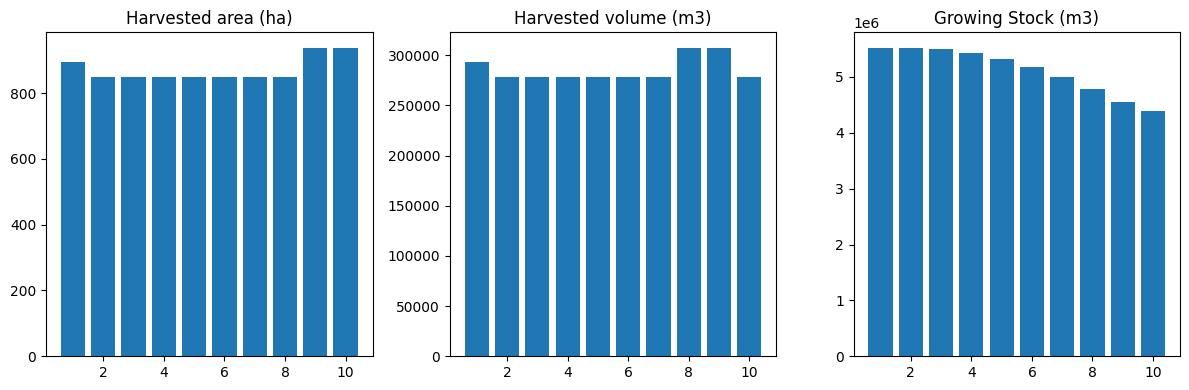

Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_business as usual_scheduling.pdf


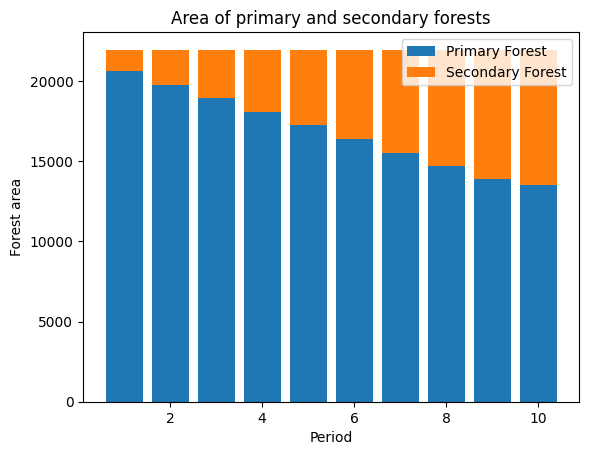

------------------------------------------------
The scocial indicator (the number of job creation) is:  3018
The economic indicator (the provincial government revenues) is:  102935
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.
Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_business as usual_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                   0           10   Difference
Cedar     283.576558  1017.467588   733.891030
Aspen      42.290489   185.519499   143.229009
Spruce   4471.720232  3952.372470  -519.347762
Hem      1246.520025   734.753555  -511.766471
Birch       3.090902    26.092950    23.002049
Bal      3699.410838  4932.799186  1233.388348
DougFir   504.920628   860.516017   355.595390
Pine      156.364968   156.393578     0.028610

Old growth has **increased** by 1458.02 hectares from time period 0 to tim

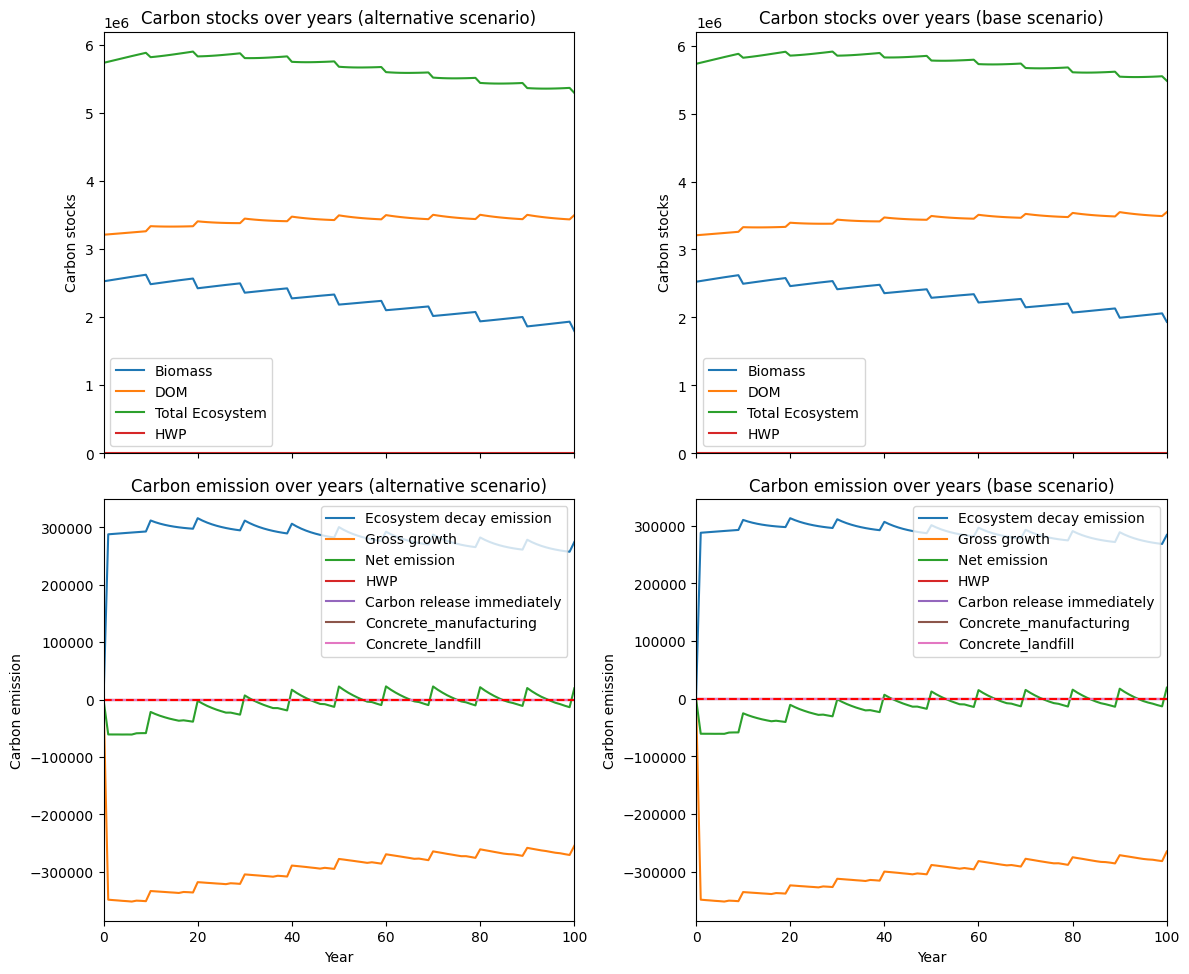

---------------------------------------------------------------------------------------
Net emission difference 453234.9344516371
Net emission base scenario -1408348.9624389294
Net emission alternative scenario -955114.027987292
dollar_per_ton is:  22.063612576772943
Comparison of Old Growth Areas (Alternative - Base)
           0          10  Difference
Cedar    0.0  141.567480  141.567480
Aspen    0.0    0.000000    0.000000
Spruce   0.0 -876.696347 -876.696347
Hem      0.0    0.000000    0.000000
Birch    0.0   14.026344   14.026344
Bal      0.0 -824.723327 -824.723327
DougFir  0.0    0.000000    0.000000
Pine     0.0    0.000000    0.000000

Overall, the old growth area has **decreased** by -1545.83 hectares in the alternative scenario compared to the base scenario.
Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_kpi_age_difference.pdf
Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/ecotrust/ecotrust_max_hv_kpi_species_difference_pie.pdf
---------------------------

/media/data/home/sghotb/.virtualenvs/foo/lib/python3.10/site-packages/pulp/pulp.py:1298: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


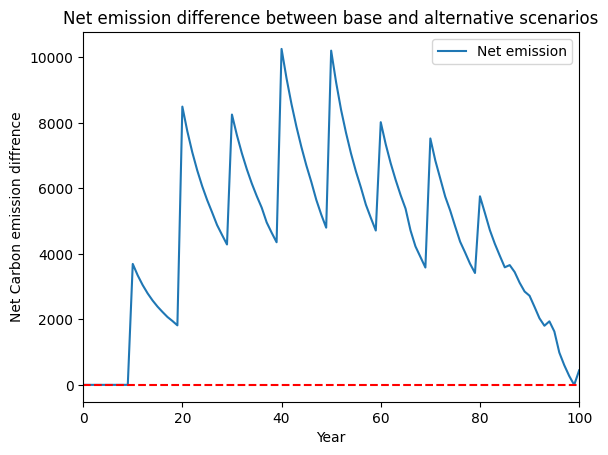

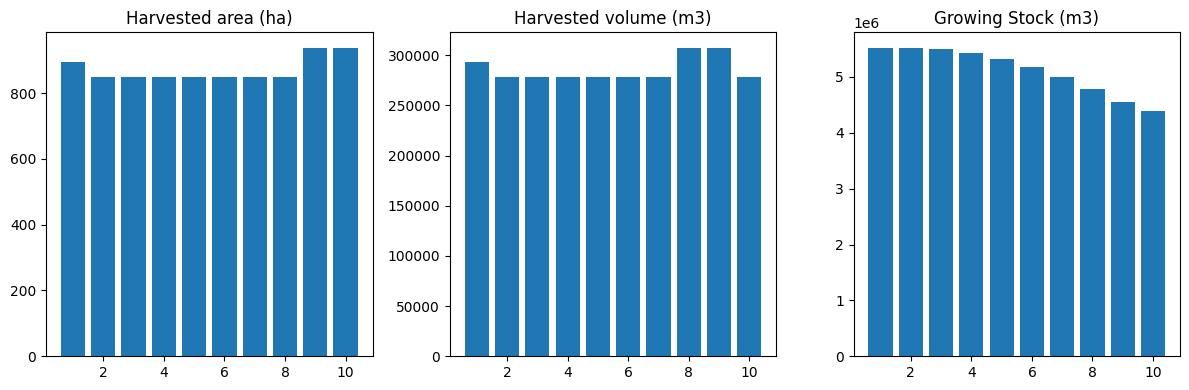

Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_business as usual_scheduling.pdf


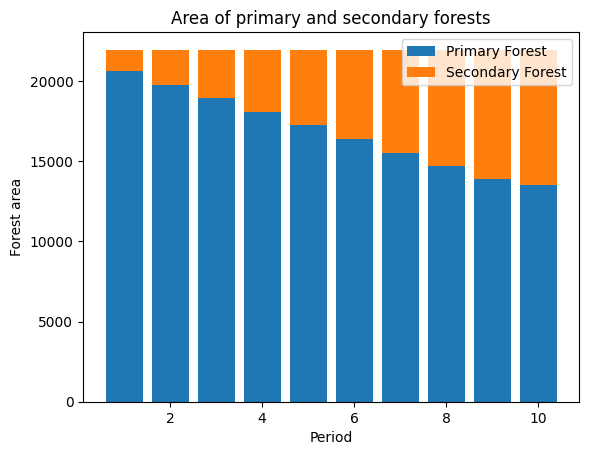

------------------------------------------------
The scocial indicator (the number of job creation) is:  3018
The economic indicator (the provincial government revenues) is:  102935
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.
Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_business as usual_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                   0           10   Difference
Cedar     283.576558  1017.467588   733.891030
Aspen      42.290489   185.519499   143.229009
Spruce   4471.720232  3952.372470  -519.347762
Hem      1246.520025   734.753555  -511.766471
Birch       3.090902    26.092950    23.002049
Bal      3699.410838  4932.799186  1233.388348
DougFir   504.920628   860.516017   355.595390
Pine      156.364968   156.393578     0.028610

Old growth has **increased** by 1458.02 hectares from time period 0 to tim

/media/data/home/sghotb/.virtualenvs/foo/lib/python3.10/site-packages/pulp/pulp.py:1298: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


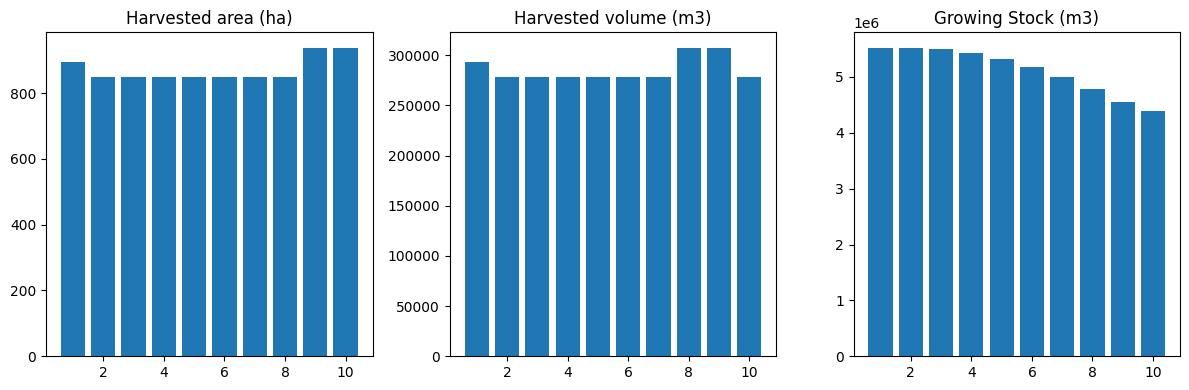

Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_business as usual_scheduling.pdf


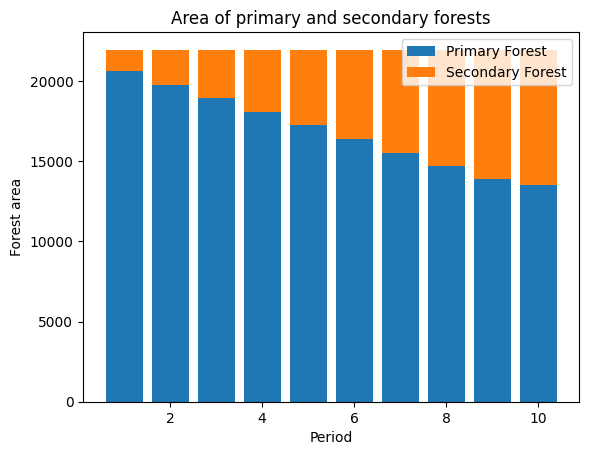

------------------------------------------------
The scocial indicator (the number of job creation) is:  3018
The economic indicator (the provincial government revenues) is:  102935
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.
Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_business as usual_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                   0           10   Difference
Cedar     283.576558  1017.467588   733.891030
Aspen      42.290489   185.519499   143.229009
Spruce   4471.720232  3952.372470  -519.347762
Hem      1246.520025   734.753555  -511.766471
Birch       3.090902    26.092950    23.002049
Bal      3699.410838  4932.799186  1233.388348
DougFir   504.920628   860.516017   355.595390
Pine      156.364968   156.393578     0.028610

Old growth has **increased** by 1458.02 hectares from time period 0 to tim

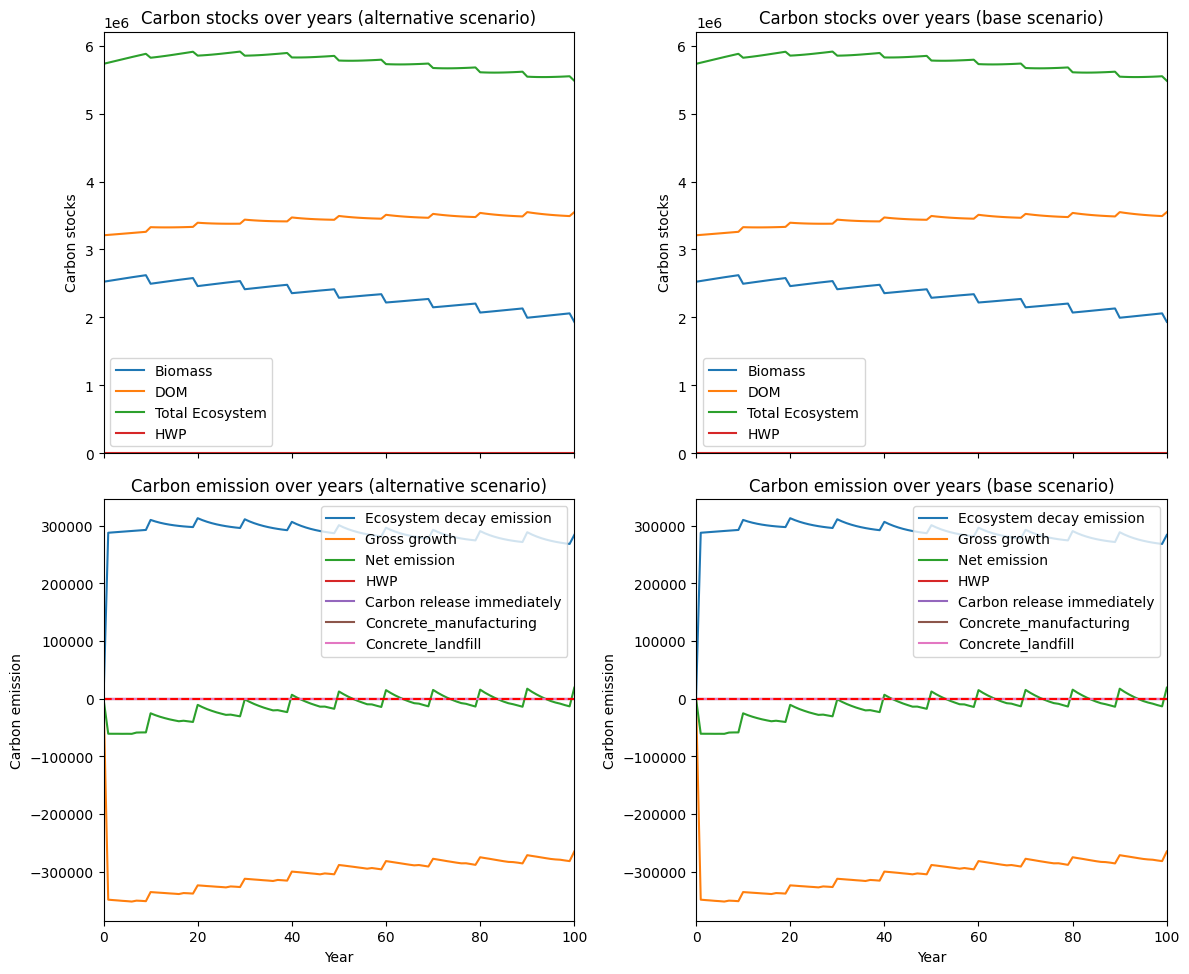

---------------------------------------------------------------------------------------
Net emission difference 0.0
Net emission base scenario -1408348.9624389294
Net emission alternative scenario -1408348.9624389294
dollar_per_ton is:  inf
Comparison of Old Growth Areas (Alternative - Base)
           0   10  Difference
Cedar    0.0  0.0         0.0
Aspen    0.0  0.0         0.0
Spruce   0.0  0.0         0.0
Hem      0.0  0.0         0.0
Birch    0.0  0.0         0.0
Bal      0.0  0.0         0.0
DougFir  0.0  0.0         0.0
Pine     0.0  0.0         0.0

Overall, the old growth area has **increased** by 0.00 hectares in the alternative scenario compared to the base scenario.


/media/data/project/sghotb/ecotrust-dss/util.py:1290: RuntimeWarning: divide by zero encountered in scalar divide
  dollar_per_ton = abs(budget_input / dif_scenario['Net emission'].sum()) # Calculate for the next 25 years


Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_kpi_age_difference.pdf
Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/ecotrust/ecotrust_max_hv_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for ecotrust_max_hv_40% of highest carbon stock...
running 40% of highest carbon stock scenario


/media/data/home/sghotb/.virtualenvs/foo/lib/python3.10/site-packages/pulp/pulp.py:1298: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


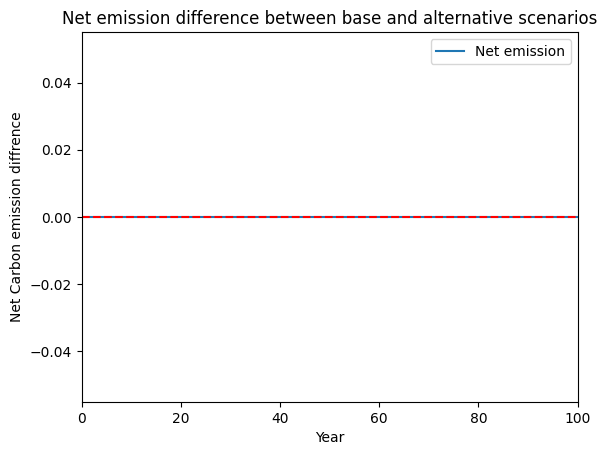

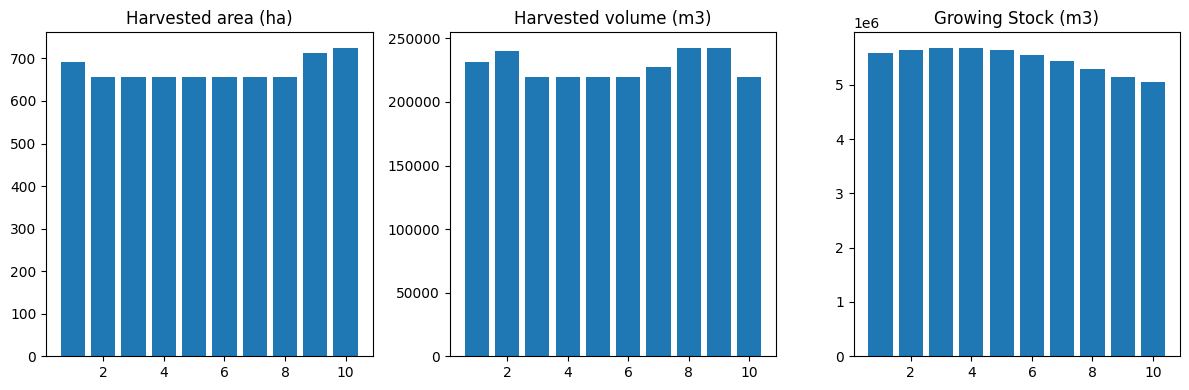

Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_40% of highest carbon stock_scheduling.pdf


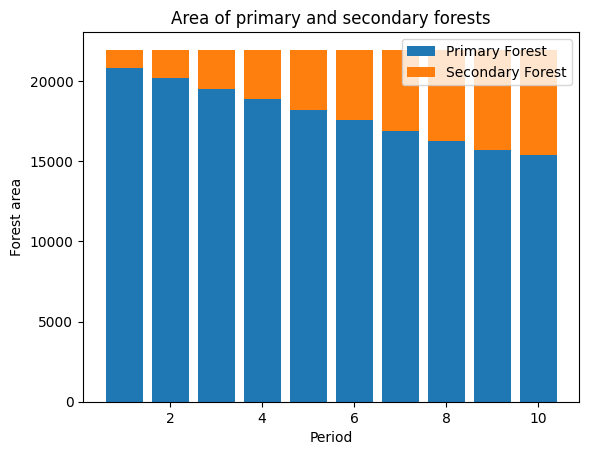

------------------------------------------------
The scocial indicator (the number of job creation) is:  2411
The economic indicator (the provincial government revenues) is:  82238
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.
Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_40% of highest carbon stock_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                   0           10   Difference
Cedar     283.576558  1090.170104   806.593546
Aspen      42.290489   191.967813   149.677323
Spruce   4471.720232  5078.424949   606.704717
Hem      1246.520025  1032.205554  -214.314471
Birch       3.090902    26.092950    23.002049
Bal      3699.410838  5020.327392  1320.916554
DougFir   504.920628   874.268726   369.348099
Pine      156.364968   169.653006    13.288037

Old growth has **increased** by 3075.22 hectares from time period

/media/data/home/sghotb/.virtualenvs/foo/lib/python3.10/site-packages/pulp/pulp.py:1298: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


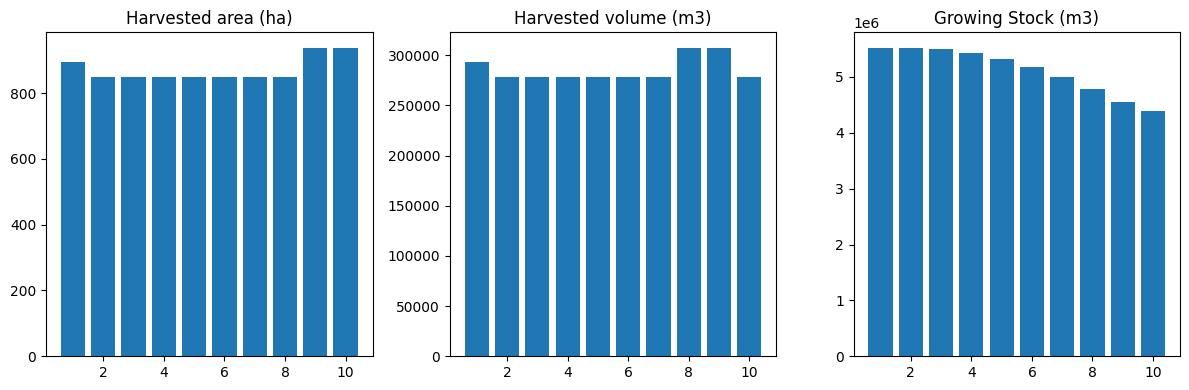

Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_business as usual_scheduling.pdf


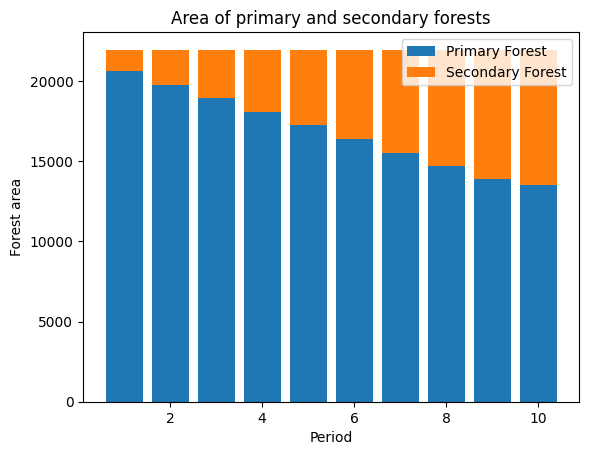

------------------------------------------------
The scocial indicator (the number of job creation) is:  3018
The economic indicator (the provincial government revenues) is:  102935
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.
Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_business as usual_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                   0           10   Difference
Cedar     283.576558  1017.467588   733.891030
Aspen      42.290489   185.519499   143.229009
Spruce   4471.720232  3952.372470  -519.347762
Hem      1246.520025   734.753555  -511.766471
Birch       3.090902    26.092950    23.002049
Bal      3699.410838  4932.799186  1233.388348
DougFir   504.920628   860.516017   355.595390
Pine      156.364968   156.393578     0.028610

Old growth has **increased** by 1458.02 hectares from time period 0 to tim

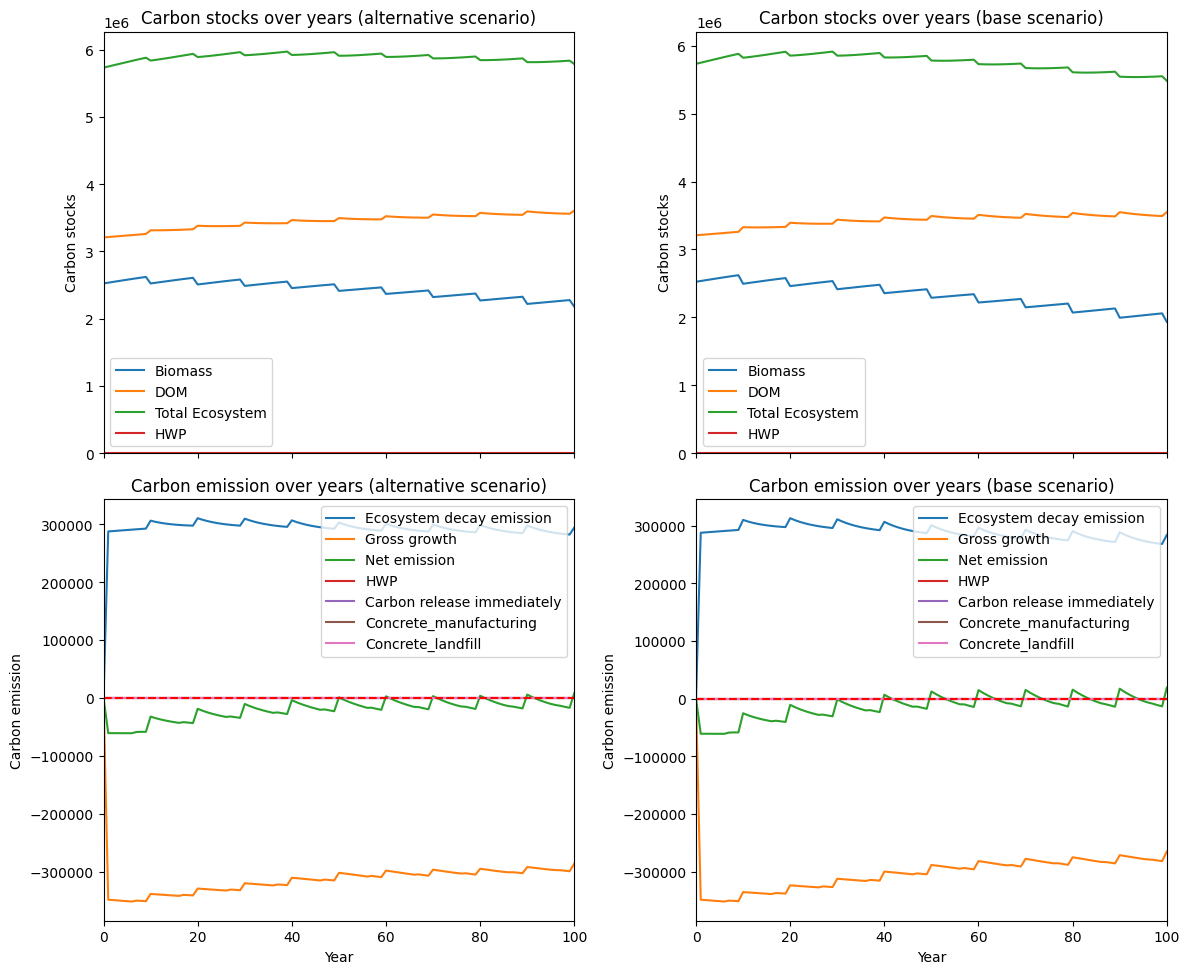

---------------------------------------------------------------------------------------
Net emission difference -653888.4181591626
Net emission base scenario -1408348.9624389294
Net emission alternative scenario -2062237.3805980918
dollar_per_ton is:  15.29312910626581
Comparison of Old Growth Areas (Alternative - Base)
           0           10   Difference
Cedar    0.0    72.702516    72.702516
Aspen    0.0     6.448314     6.448314
Spruce   0.0  1126.052478  1126.052478
Hem      0.0   297.451999   297.451999
Birch    0.0     0.000000     0.000000
Bal      0.0    87.528206    87.528206
DougFir  0.0    13.752709    13.752709
Pine     0.0    13.259427    13.259427

Overall, the old growth area has **increased** by 1617.20 hectares in the alternative scenario compared to the base scenario.
Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_kpi_age_difference.pdf
Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/ecotrust/ecotrust_max_hv_kpi_species_difference_pie.pdf
--------

/media/data/home/sghotb/.virtualenvs/foo/lib/python3.10/site-packages/pulp/pulp.py:1298: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


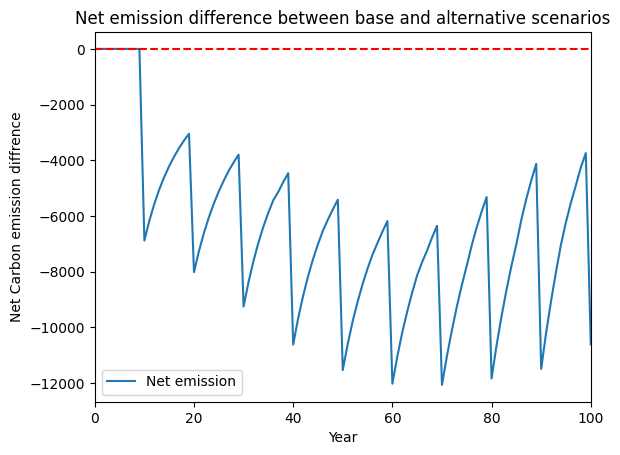

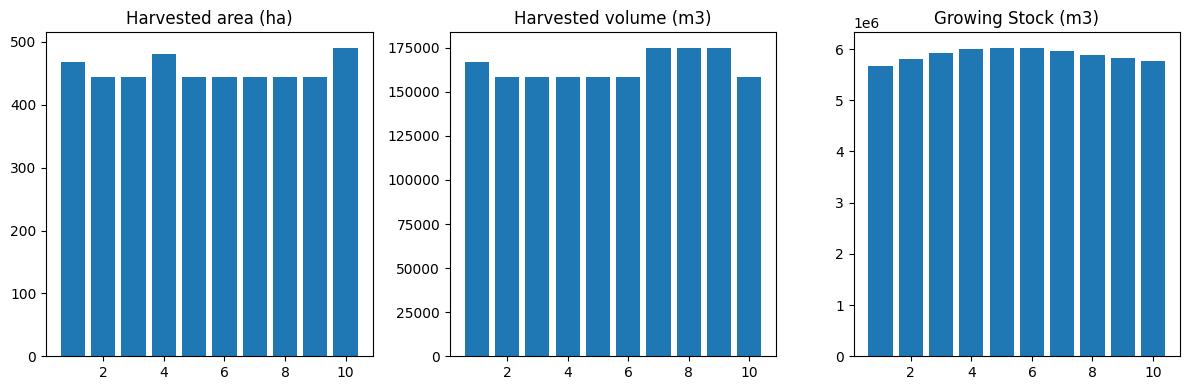

Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_60% of highest carbon stock_scheduling.pdf


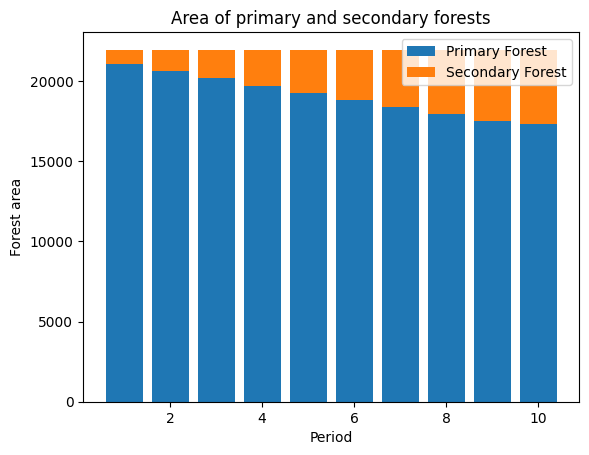

------------------------------------------------
The scocial indicator (the number of job creation) is:  1735
The economic indicator (the provincial government revenues) is:  59172
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.
Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_60% of highest carbon stock_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                   0           10   Difference
Cedar     283.576558  1507.074823  1223.498265
Aspen      42.290489   259.673913   217.383424
Spruce   4471.720232  5254.425701   782.705470
Hem      1246.520025  1590.711518   344.191493
Birch       3.090902    40.119295    37.028393
Bal      3699.410838  5278.623945  1579.213107
DougFir   504.920628   951.967410   447.046782
Pine      156.364968   204.552976    48.188007

Old growth has **increased** by 4679.25 hectares from time period

/media/data/home/sghotb/.virtualenvs/foo/lib/python3.10/site-packages/pulp/pulp.py:1298: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


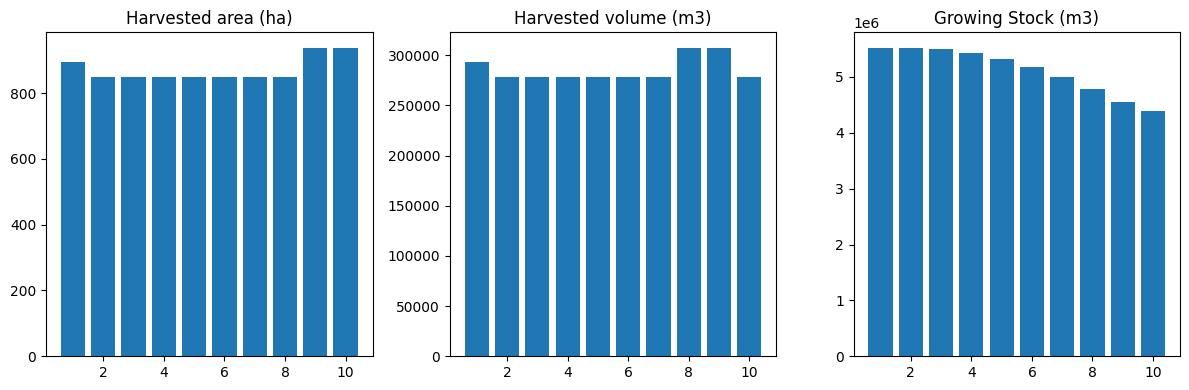

Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_business as usual_scheduling.pdf


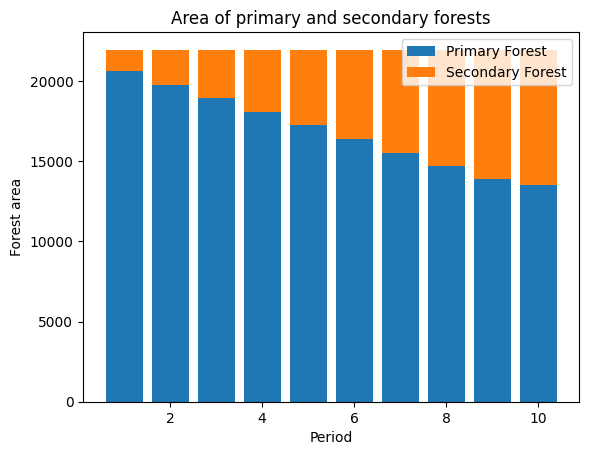

------------------------------------------------
The scocial indicator (the number of job creation) is:  3018
The economic indicator (the provincial government revenues) is:  102935
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.
Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_business as usual_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                   0           10   Difference
Cedar     283.576558  1017.467588   733.891030
Aspen      42.290489   185.519499   143.229009
Spruce   4471.720232  3952.372470  -519.347762
Hem      1246.520025   734.753555  -511.766471
Birch       3.090902    26.092950    23.002049
Bal      3699.410838  4932.799186  1233.388348
DougFir   504.920628   860.516017   355.595390
Pine      156.364968   156.393578     0.028610

Old growth has **increased** by 1458.02 hectares from time period 0 to tim

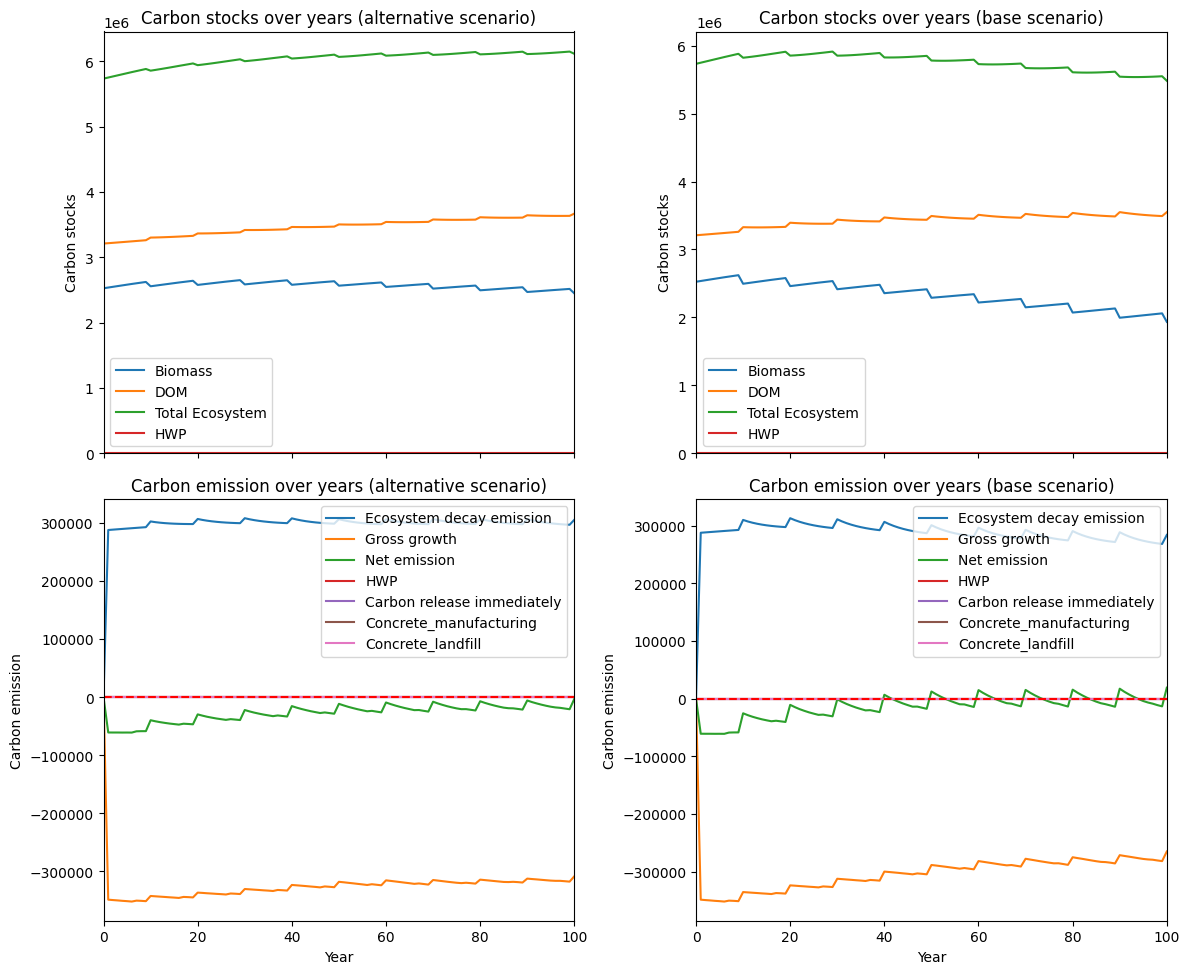

---------------------------------------------------------------------------------------
Net emission difference -1326770.5567691308
Net emission base scenario -1408348.9624389294
Net emission alternative scenario -2735119.519208059
dollar_per_ton is:  7.537098218663654
Comparison of Old Growth Areas (Alternative - Base)
           0           10   Difference
Cedar    0.0   489.607235   489.607235
Aspen    0.0    74.154414    74.154414
Spruce   0.0  1302.053231  1302.053231
Hem      0.0   855.957964   855.957964
Birch    0.0    14.026344    14.026344
Bal      0.0   345.824759   345.824759
DougFir  0.0    91.451393    91.451393
Pine     0.0    48.159397    48.159397

Overall, the old growth area has **increased** by 3221.23 hectares in the alternative scenario compared to the base scenario.
Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_kpi_age_difference.pdf
Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/ecotrust/ecotrust_max_hv_kpi_species_difference_pie.pdf
--------

/media/data/home/sghotb/.virtualenvs/foo/lib/python3.10/site-packages/pulp/pulp.py:1298: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


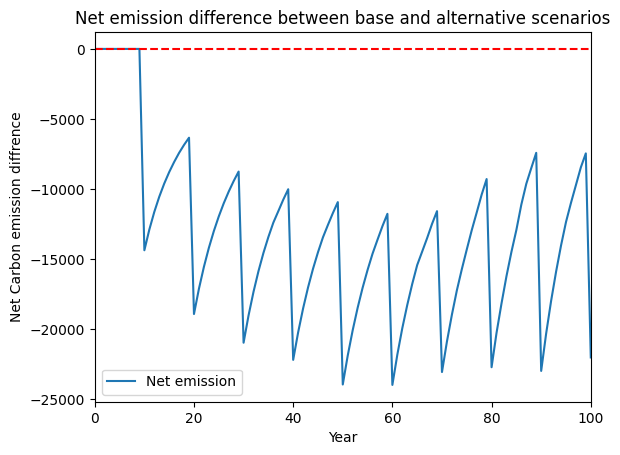

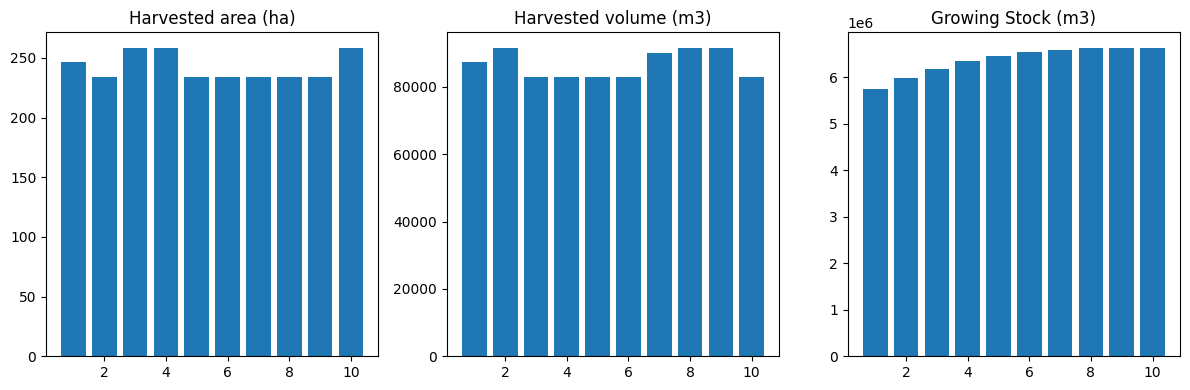

Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_20% of highest carbon stock_scheduling.pdf


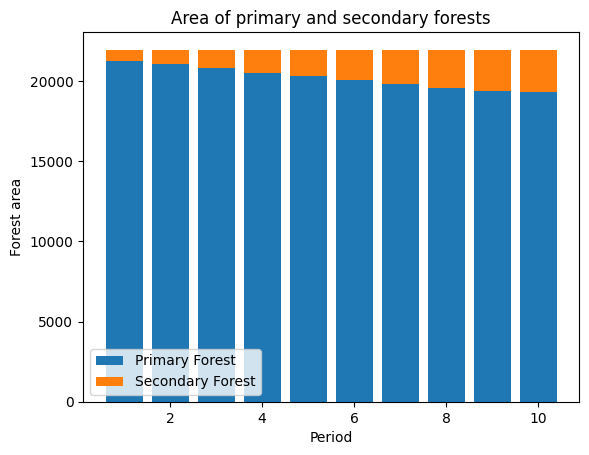

------------------------------------------------
The scocial indicator (the number of job creation) is:  916
The economic indicator (the provincial government revenues) is:  31249
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.
Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_20% of highest carbon stock_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                   0           10   Difference
Cedar     283.576558  1675.880171  1392.303613
Aspen      42.290489   283.386270   241.095780
Spruce   4471.720232  6637.699149  2165.978917
Hem      1246.520025  1590.711518   344.191493
Birch       3.090902    40.119295    37.028393
Bal      3699.410838  5331.685081  1632.274244
DougFir   504.920628  1129.078224   624.157597
Pine      156.364968   204.552976    48.188007

Old growth has **increased** by 6485.22 hectares from time period 

/media/data/home/sghotb/.virtualenvs/foo/lib/python3.10/site-packages/pulp/pulp.py:1298: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


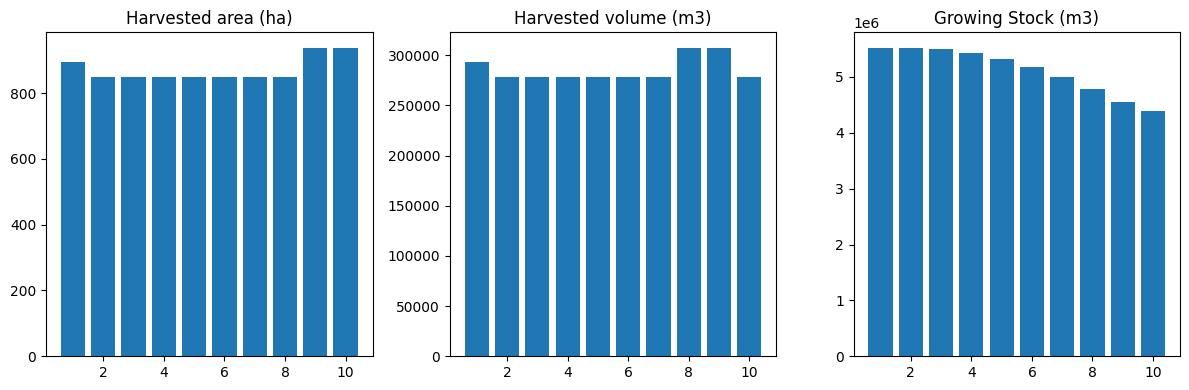

Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_business as usual_scheduling.pdf


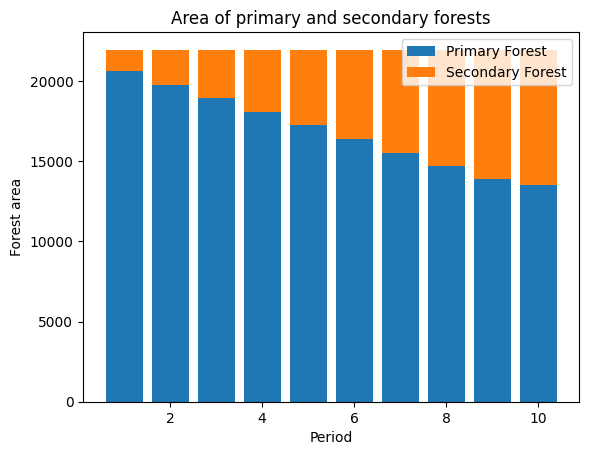

------------------------------------------------
The scocial indicator (the number of job creation) is:  3018
The economic indicator (the provincial government revenues) is:  102935
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.
Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_business as usual_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                   0           10   Difference
Cedar     283.576558  1017.467588   733.891030
Aspen      42.290489   185.519499   143.229009
Spruce   4471.720232  3952.372470  -519.347762
Hem      1246.520025   734.753555  -511.766471
Birch       3.090902    26.092950    23.002049
Bal      3699.410838  4932.799186  1233.388348
DougFir   504.920628   860.516017   355.595390
Pine      156.364968   156.393578     0.028610

Old growth has **increased** by 1458.02 hectares from time period 0 to tim

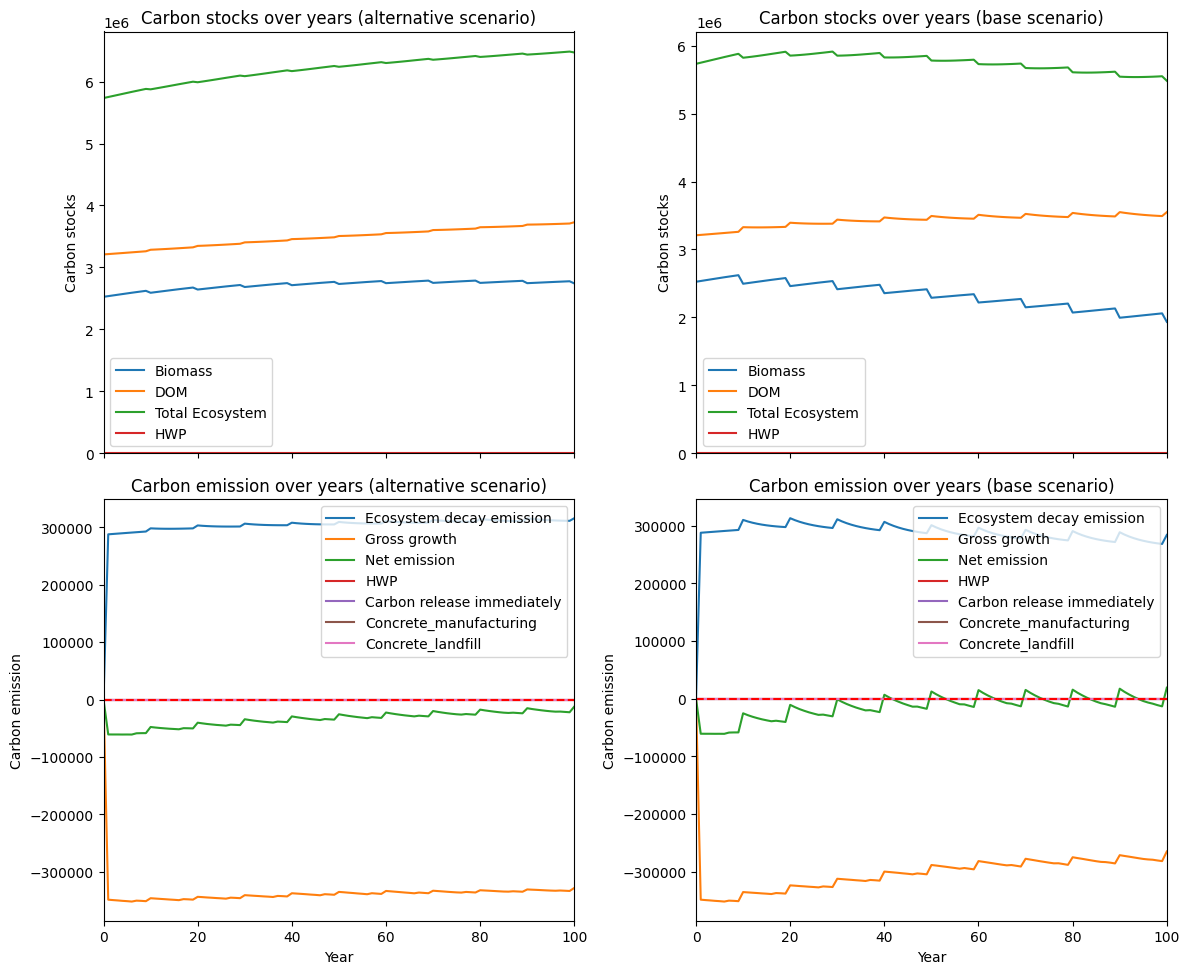

---------------------------------------------------------------------------------------
Net emission difference -2009150.4734349372
Net emission base scenario -1408348.9624389294
Net emission alternative scenario -3417499.4358738665
dollar_per_ton is:  4.977228003686322
Comparison of Old Growth Areas (Alternative - Base)
           0           10   Difference
Cedar    0.0   658.412583   658.412583
Aspen    0.0    97.866771    97.866771
Spruce   0.0  2685.326679  2685.326679
Hem      0.0   855.957964   855.957964
Birch    0.0    14.026344    14.026344
Bal      0.0   398.885895   398.885895
DougFir  0.0   268.562207   268.562207
Pine     0.0    48.159397    48.159397

Overall, the old growth area has **increased** by 5027.20 hectares in the alternative scenario compared to the base scenario.
Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_kpi_age_difference.pdf
Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/ecotrust/ecotrust_max_hv_kpi_species_difference_pie.pdf
-------

/media/data/home/sghotb/.virtualenvs/foo/lib/python3.10/site-packages/pulp/pulp.py:1298: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


apply action error 1 ('tsa17', '1', '734', '100', '734', '1') harvest 1 233 -3.504201687899414e-11
apply action error 1 ('tsa17', '1', '356', '500', '356', '1') harvest 2 294 -2.3343659650647514e-10
apply action error 1 ('tsa17', '1', '735', '100', '735', '1') harvest 2 123 -6.144322018978715e-11
apply action error 1 ('tsa17', '1', '336', '1211', '336', '1') harvest 3 134 -3.3965146866467044e-10
apply action error 1 ('tsa17', '1', '357', '500', '357', '1') harvest 5 156 -2.57659841443143e-10
apply action error 1 ('tsa17', '1', '357', '500', '357', '1') harvest 6 162 -9.113734920109288e-11
apply action error 1 ('tsa17', '1', '387', '100', '387', '1') harvest 6 334 -1.945296003266422e-10
apply action error 1 ('tsa17', '1', '702', '702', '702', '1') harvest 6 421 -4.1416396237710535e-11
apply action error 1 ('tsa17', '1', '306', '100', '306', '1') harvest 7 401 -1.3397994689262484e-10
apply action error 1 ('tsa17', '1', '388', '100', '388', '1') harvest 8 191 -5.057294740011521e-11
apply 

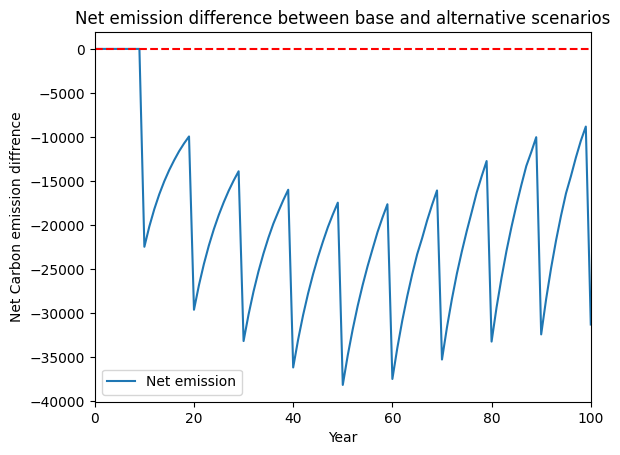

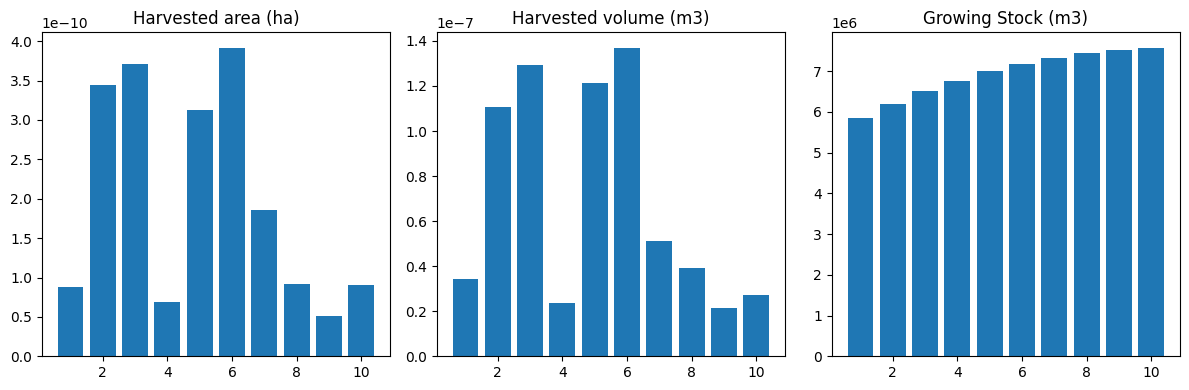

Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_highest carbon stock_scheduling.pdf


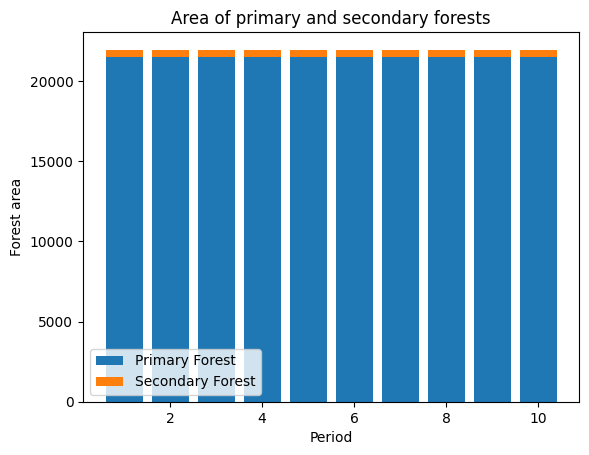

------------------------------------------------
The scocial indicator (the number of job creation) is:  0
The economic indicator (the provincial government revenues) is:  0
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.
Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_highest carbon stock_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                   0           10   Difference
Cedar     283.576558  2289.652623  2006.076065
Aspen      42.290489   519.192325   476.901835
Spruce   4471.720232  7098.592523  2626.872291
Hem      1246.520025  1621.166502   374.646477
Birch       3.090902    40.119295    37.028393
Bal      3699.410838  5331.685081  1632.274244
DougFir   504.920628  1597.575721  1092.655093
Pine      156.364968   204.552976    48.188007

Old growth has **increased** by 8294.64 hectares from time period 0 to time per

/media/data/home/sghotb/.virtualenvs/foo/lib/python3.10/site-packages/pulp/pulp.py:1298: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


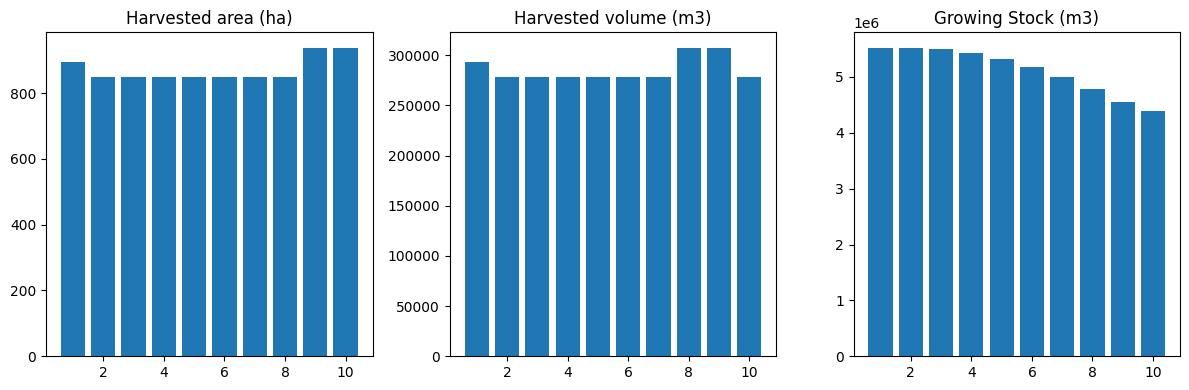

Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_business as usual_scheduling.pdf


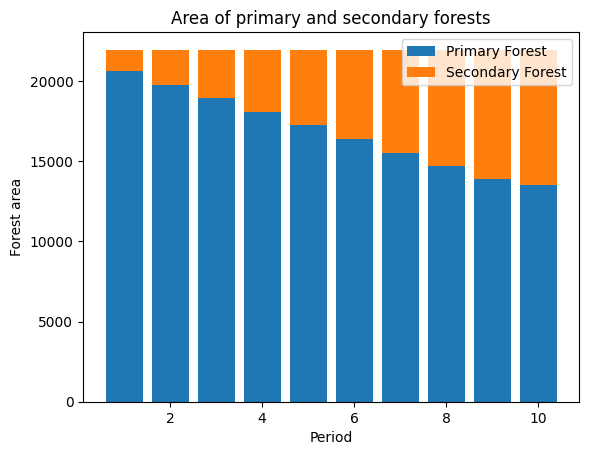

------------------------------------------------
The scocial indicator (the number of job creation) is:  3018
The economic indicator (the provincial government revenues) is:  102935
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.
Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_business as usual_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                   0           10   Difference
Cedar     283.576558  1017.467588   733.891030
Aspen      42.290489   185.519499   143.229009
Spruce   4471.720232  3952.372470  -519.347762
Hem      1246.520025   734.753555  -511.766471
Birch       3.090902    26.092950    23.002049
Bal      3699.410838  4932.799186  1233.388348
DougFir   504.920628   860.516017   355.595390
Pine      156.364968   156.393578     0.028610

Old growth has **increased** by 1458.02 hectares from time period 0 to tim

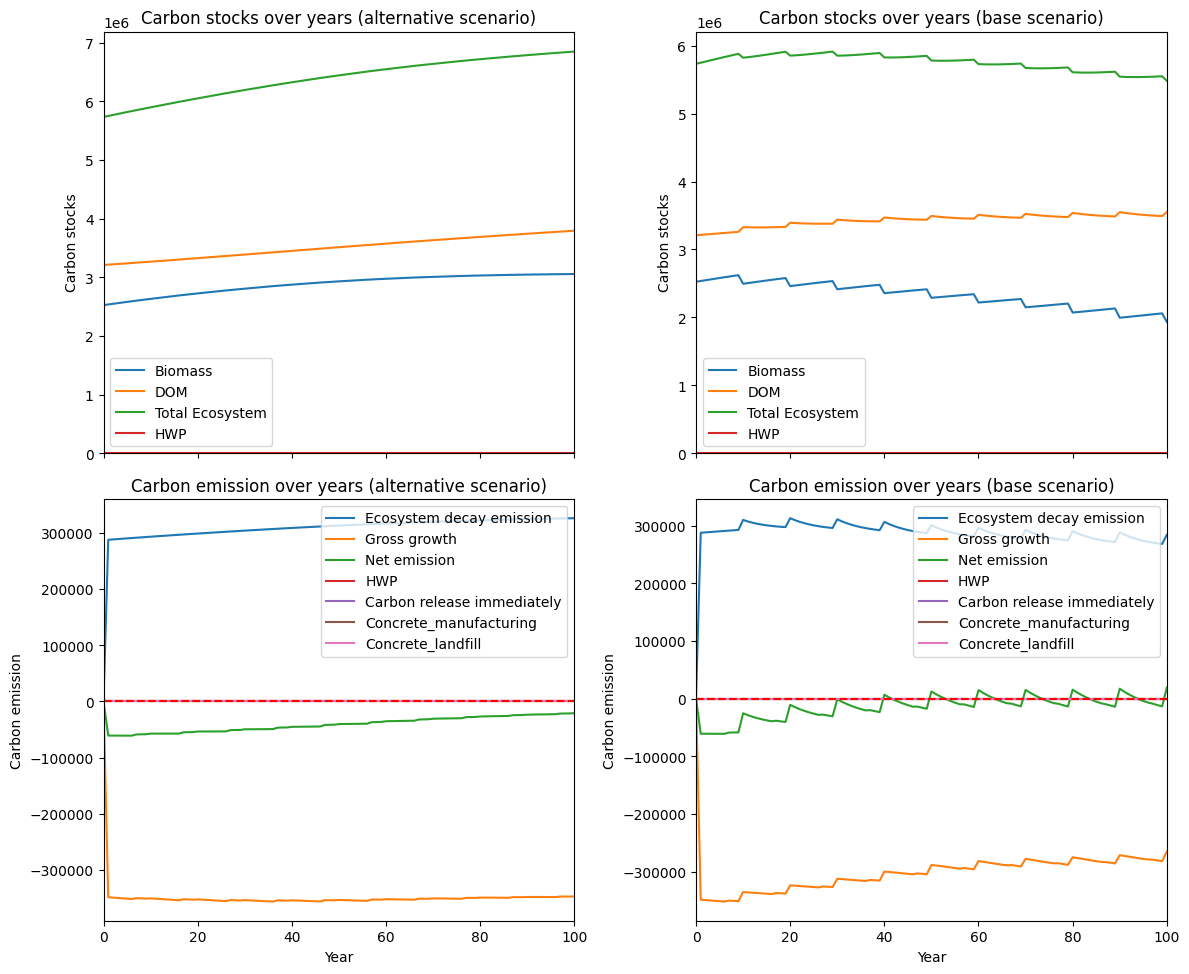

---------------------------------------------------------------------------------------
Net emission difference -2676160.2342940117
Net emission base scenario -1408348.9624389294
Net emission alternative scenario -4084509.1967329415
dollar_per_ton is:  3.7366970302651046
Comparison of Old Growth Areas (Alternative - Base)
           0           10   Difference
Cedar    0.0  1272.185035  1272.185035
Aspen    0.0   333.672826   333.672826
Spruce   0.0  3146.220053  3146.220053
Hem      0.0   886.412947   886.412947
Birch    0.0    14.026344    14.026344
Bal      0.0   398.885895   398.885895
DougFir  0.0   737.059704   737.059704
Pine     0.0    48.159397    48.159397

Overall, the old growth area has **increased** by 6836.62 hectares in the alternative scenario compared to the base scenario.
Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_kpi_age_difference.pdf
Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/ecotrust/ecotrust_max_hv_kpi_species_difference_pie.pdf
------

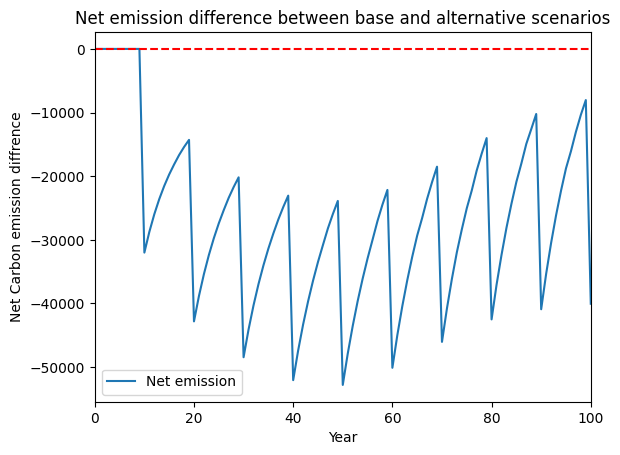

In [25]:
Start = time.time()
epsilon_bd, bd_max = epsilon_computer_bd(fm, clt_percentage, hwp_pool_effect_value, displacement_effect, release_immediately_value, n=10, solver=ws3.opt.SOLVER_PULP)
epsilon, cs_max = epsilon_computer(fm, clt_percentage, hwp_pool_effect_value, displacement_effect, release_immediately_value, n=10, solver=ws3.opt.SOLVER_PULP)
scenario_names = scenario_options.get(case_study, [])
for scenario_name in scenario_names:
    print(f"Running for {case_study}_{obj_mode}_{scenario_name}...")
    results_scenarios(fm, 
                      clt_percentage, 
                      credibility, 
                      budget_input, 
                      n_steps, 
                      max_harvest, 
                      scenario_name, 
                      displacement_effect, 
                      hwp_pool_effect_value, 
                      release_immediately_value, 
                      case_study, 
                      obj_mode, 
                      epsilon,
                      cs_max,
                      pickle_output_base=False, 
                      pickle_output_alter=False)
print('It took', round((time.time() - Start) / 60, 1), "minutes to run all scenarios.")